__Import Library__

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

1. Load Dataset & inspect

In [2]:
train_df = pd.read_csv('./dataset/new_train.csv')
test_df = pd.read_csv('./dataset/new_test.csv')

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

# print(train_df.head())

Train shape: (32950, 16)
Test shape: (8238, 13)


2. Convert target to 0/1

In [3]:
train_df['y'] = train_df['y'].map({'no': 0, 'yes': 1})

3. Define categorical and numeric columns

In [4]:
categorical_cols = [
    'job', 'marital', 'education', 'default',
    'housing', 'loan', 'contact', 'month',
    'day_of_week', 'poutcome'
]

numeric_cols = [
    'age', 'duration', 'campaign', 'pdays', 'previous'
]

4. One-hot encode categorical columns

In [5]:
train_enc = pd.get_dummies(train_df, columns=categorical_cols, drop_first=True)
test_enc  = pd.get_dummies(test_df,  columns=categorical_cols, drop_first=True)

# align test columns to train columns
test_enc = test_enc.reindex(columns=train_enc.drop('y', axis=1).columns, fill_value=0)

5. TRAIN/TEST SPLIT

In [6]:
from sklearn.utils import class_weight
import numpy as np

X = train_enc.drop('y', axis=1)
y = train_enc['y']

# split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train:", X_train.shape)
print("Validation:", X_val.shape)
# print(X_train.head())

Train: (26360, 48)
Validation: (6590, 48)


6. SCALING

In [7]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(test_enc)

input_dim = X_train_scaled.shape[1]
print("Input features:", input_dim)

# Reshape for LSTM → (samples, timesteps, features)
X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], input_dim, 1))
X_val_lstm   = X_val_scaled.reshape((X_val_scaled.shape[0], input_dim, 1))

Input features: 48


7. ANN Model With early stopping

In [8]:
early_stop_ann = EarlyStopping(
    monitor='val_loss', patience=5,
    restore_best_weights=True, verbose=1
)

model_ann = Sequential([
    Dense(128, activation='relu', input_shape=(input_dim,)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_ann.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history_ann = model_ann.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=100,
    batch_size=128,
    callbacks=[early_stop_ann],
    verbose=1
)

ann_loss, ann_acc = model_ann.evaluate(X_val_scaled, y_val, verbose=0)
print(f"\nANN Accuracy: {ann_acc:.4f}")
print(f"ANN Loss: {ann_loss:.4f}\n")

Epoch 1/100
206/206 [==============================] - 4s 6ms/step - loss: 0.2766 - accuracy: 0.8956 - val_loss: 0.2182 - val_accuracy: 0.9038
Epoch 2/100
206/206 [==============================] - 1s 5ms/step - loss: 0.2253 - accuracy: 0.9026 - val_loss: 0.2130 - val_accuracy: 0.9050
Epoch 3/100
206/206 [==============================] - 1s 5ms/step - loss: 0.2196 - accuracy: 0.9024 - val_loss: 0.2120 - val_accuracy: 0.9055
Epoch 4/100
206/206 [==============================] - 1s 5ms/step - loss: 0.2136 - accuracy: 0.9035 - val_loss: 0.2118 - val_accuracy: 0.9052
Epoch 5/100
206/206 [==============================] - 1s 5ms/step - loss: 0.2104 - accuracy: 0.9045 - val_loss: 0.2096 - val_accuracy: 0.9073
Epoch 6/100
206/206 [==============================] - 1s 5ms/step - loss: 0.2080 - accuracy: 0.9073 - val_loss: 0.2078 - val_accuracy: 0.9068
Epoch 7/100
206/206 [==============================] - 1s 4ms/step - loss: 0.2068 - accuracy: 0.9064 - val_loss: 0.2081 - val_accuracy: 0.9085

__Import Library for confusion matrix, accuracy graph, loss graph__

In [30]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

8.1 Confusion Matrix for ANN

206/206 [==============================] - 0s 1ms/step


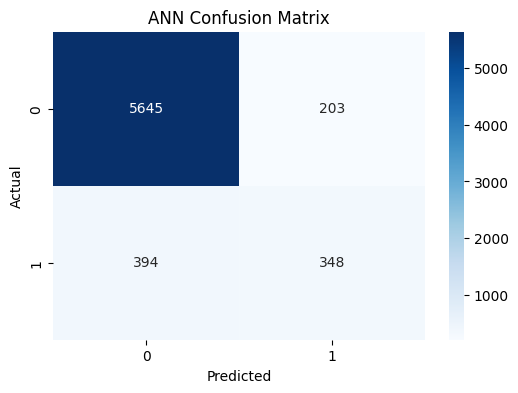

ANN Classification Report:

              precision    recall  f1-score   support

           0       0.93      0.97      0.95      5848
           1       0.63      0.47      0.54       742

    accuracy                           0.91      6590
   macro avg       0.78      0.72      0.74      6590
weighted avg       0.90      0.91      0.90      6590



In [31]:
# Predict classes on validation data
val_pred_ann = (model_ann.predict(X_val_scaled) >= 0.5).astype(int)

# Confusion matrix for ANN
cm_ann = confusion_matrix(y_val, val_pred_ann)

plt.figure(figsize=(6,4))
sns.heatmap(cm_ann, annot=True, fmt="d", cmap="Blues")
plt.title("ANN Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification report (precision, recall, f1)
print("ANN Classification Report:\n")
print(classification_report(y_val, val_pred_ann))

8.2 Accuracy Graph (ANN)

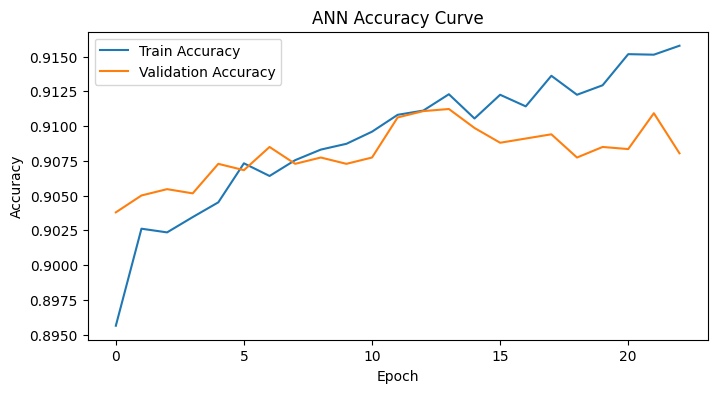

In [32]:
plt.figure(figsize=(8,4))
plt.plot(history_ann.history['accuracy'], label='Train Accuracy')
plt.plot(history_ann.history['val_accuracy'], label='Validation Accuracy')
plt.title("ANN Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

8.3 Loss Graph (ANN)

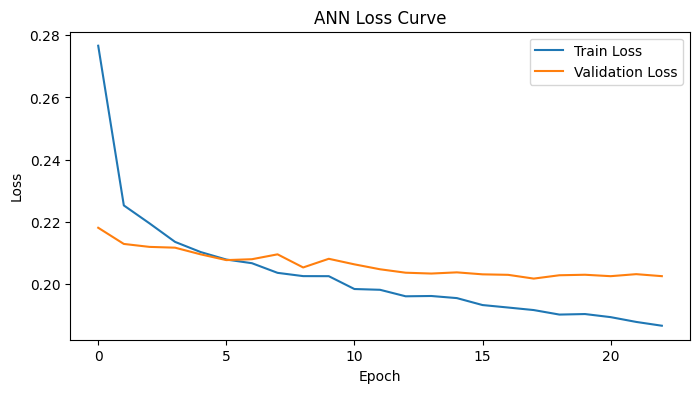

In [33]:
plt.figure(figsize=(8,4))
plt.plot(history_ann.history['loss'], label='Train Loss')
plt.plot(history_ann.history['val_loss'], label='Validation Loss')
plt.title("ANN Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

9. CNN MODEL: (1D CNN on TABULAR DATA)

In [9]:
# reshape for CNN (samples, features, 1)
X_train_cnn = X_train_scaled.reshape((X_train_scaled.shape[0], input_dim, 1))
X_val_cnn   = X_val_scaled.reshape((X_val_scaled.shape[0], input_dim, 1))
X_test_cnn  = X_test_scaled.reshape((X_test_scaled.shape[0], input_dim, 1))

early_stop_cnn = EarlyStopping(
    monitor='val_loss', patience=5,
    restore_best_weights=True, verbose=1
)

model_cnn = Sequential([
    Conv1D(32, kernel_size=3, activation='relu', input_shape=(input_dim, 1)),
    MaxPooling1D(pool_size=2),

    Conv1D(64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model_cnn.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history_cnn = model_cnn.fit(
    X_train_cnn, y_train,
    validation_data=(X_val_cnn, y_val),
    epochs=100,
    batch_size=64,
    callbacks=[early_stop_cnn],
    verbose=1
)

cnn_loss, cnn_acc = model_cnn.evaluate(X_val_cnn, y_val, verbose=0)
print(f"\nCNN Accuracy: {cnn_acc:.4f}")
print(f"CNN Loss: {cnn_loss:.4f}\n")

Epoch 1/100
412/412 [==============================] - 7s 6ms/step - loss: 0.2771 - accuracy: 0.8953 - val_loss: 0.2339 - val_accuracy: 0.9020
Epoch 2/100
412/412 [==============================] - 2s 5ms/step - loss: 0.2251 - accuracy: 0.9031 - val_loss: 0.2236 - val_accuracy: 0.9015
Epoch 3/100
412/412 [==============================] - 2s 5ms/step - loss: 0.2199 - accuracy: 0.9041 - val_loss: 0.2264 - val_accuracy: 0.9036
Epoch 4/100
412/412 [==============================] - 2s 5ms/step - loss: 0.2146 - accuracy: 0.9054 - val_loss: 0.2172 - val_accuracy: 0.9064
Epoch 5/100
412/412 [==============================] - 2s 5ms/step - loss: 0.2126 - accuracy: 0.9048 - val_loss: 0.2138 - val_accuracy: 0.9058
Epoch 6/100
412/412 [==============================] - 2s 5ms/step - loss: 0.2104 - accuracy: 0.9061 - val_loss: 0.2140 - val_accuracy: 0.9062
Epoch 7/100
412/412 [==============================] - 2s 5ms/step - loss: 0.2089 - accuracy: 0.9063 - val_loss: 0.2136 - val_accuracy: 0.9076

9.1 Confusion Matrix for CNN

206/206 [==============================] - 0s 1ms/step


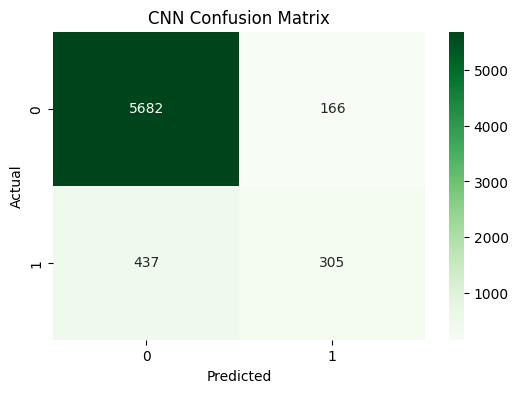

CNN Classification Report:

              precision    recall  f1-score   support

           0       0.93      0.97      0.95      5848
           1       0.65      0.41      0.50       742

    accuracy                           0.91      6590
   macro avg       0.79      0.69      0.73      6590
weighted avg       0.90      0.91      0.90      6590



In [13]:
val_pred_cnn = (model_cnn.predict(X_val_cnn) >= 0.5).astype(int)

cm_cnn = confusion_matrix(y_val, val_pred_cnn)

plt.figure(figsize=(6,4))
sns.heatmap(cm_cnn, annot=True, fmt="d", cmap="Greens")
plt.title("CNN Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("CNN Classification Report:\n")
print(classification_report(y_val, val_pred_cnn))

9.2 Accuracy Graph (CNN)

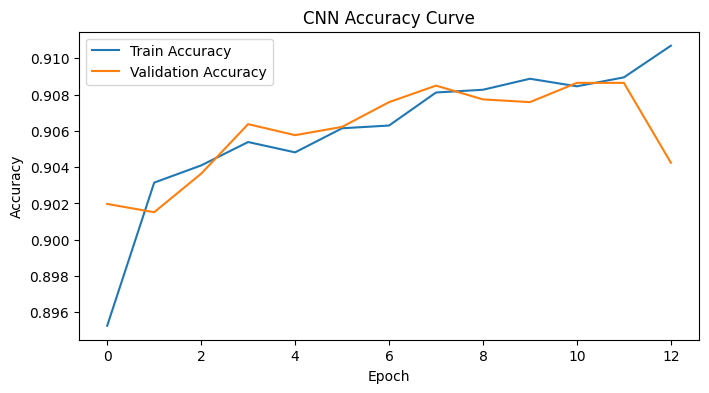

In [16]:
plt.figure(figsize=(8,4))
plt.plot(history_cnn.history['accuracy'], label='Train Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='Validation Accuracy')
plt.title("CNN Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

9.3 Loss Graph (CNN)

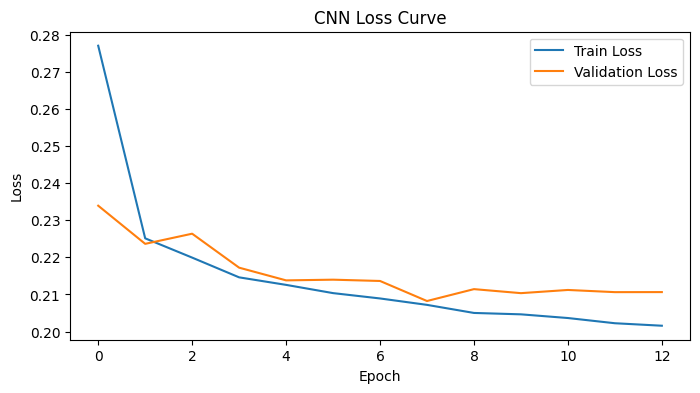

In [18]:
plt.figure(figsize=(8,4))
plt.plot(history_cnn.history['loss'], label='Train Loss')
plt.plot(history_cnn.history['val_loss'], label='Validation Loss')
plt.title("CNN Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

10. Build LSTM Model

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

early_stop_lstm = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

model_lstm = Sequential([
    LSTM(64, return_sequences=False, input_shape=(input_dim, 1)),
    Dropout(0.3),

    Dense(32, activation='relu'),
    Dropout(0.3),

    Dense(1, activation='sigmoid')
])

model_lstm.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model_lstm.summary()

history_lstm = model_lstm.fit(
    X_train_lstm, y_train,
    validation_data=(X_val_lstm, y_val),
    epochs=100,
    batch_size=64,
    callbacks=[early_stop_lstm],
    verbose=1
)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 19,009
Trainable params: 19,009
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
412/412 [=============================

10.1 Evaluate LSTM

In [20]:
lstm_loss, lstm_acc = model_lstm.evaluate(X_val_lstm, y_val, verbose=0)
print(f"\nLSTM Accuracy: {lstm_acc:.4f}")
print(f"LSTM Loss: {lstm_loss:.4f}")



LSTM Accuracy: 0.9059
LSTM Loss: 0.2106


10.2 Confusion Matrix for LSTM

206/206 [==============================] - 1s 4ms/step


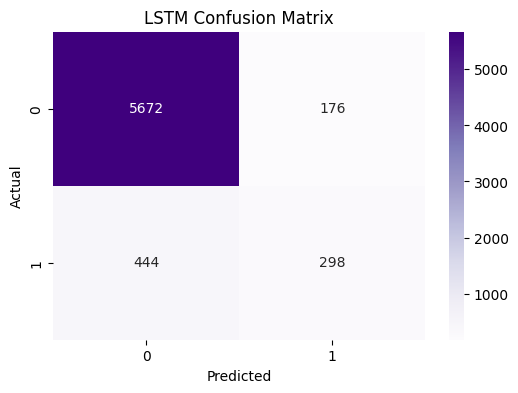


LSTM Classification Report:

              precision    recall  f1-score   support

           0       0.93      0.97      0.95      5848
           1       0.63      0.40      0.49       742

    accuracy                           0.91      6590
   macro avg       0.78      0.69      0.72      6590
weighted avg       0.89      0.91      0.90      6590



In [21]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Predictions
val_pred_lstm = (model_lstm.predict(X_val_lstm) >= 0.5).astype(int)

# Confusion Matrix
cm_lstm = confusion_matrix(y_val, val_pred_lstm)

plt.figure(figsize=(6,4))
sns.heatmap(cm_lstm, annot=True, fmt="d", cmap="Purples")
plt.title("LSTM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("\nLSTM Classification Report:\n")
print(classification_report(y_val, val_pred_lstm))


10.3 LSTM Accuracy Curve

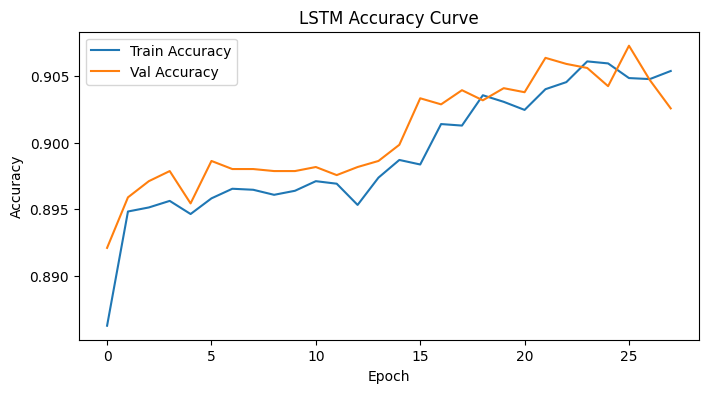

In [22]:
plt.figure(figsize=(8,4))
plt.plot(history_lstm.history['accuracy'], label='Train Accuracy')
plt.plot(history_lstm.history['val_accuracy'], label='Val Accuracy')
plt.title("LSTM Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


10.4 LSTM Loss Curve

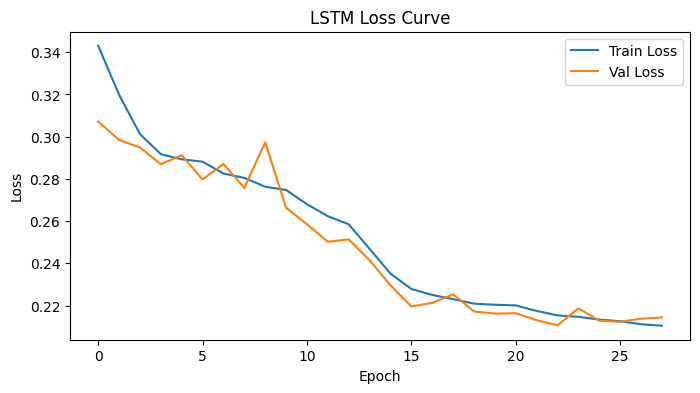

In [23]:
plt.figure(figsize=(8,4))
plt.plot(history_lstm.history['loss'], label='Train Loss')
plt.plot(history_lstm.history['val_loss'], label='Val Loss')
plt.title("LSTM Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


11. GRU MODEL

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

early_stop_gru = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

model_gru = Sequential([
    GRU(64, return_sequences=False, input_shape=(input_dim, 1)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model_gru.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model_gru.summary()

history_gru = model_gru.fit(
    X_train_lstm, y_train,
    validation_data=(X_val_lstm, y_val),
    epochs=100,
    batch_size=64,
    callbacks=[early_stop_gru],
    verbose=1
)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 64)                12864     
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 32)                2080      
                                                                 
 dropout_6 (Dropout)         (None, 32)                0         
                                                                 
 dense_9 (Dense)             (None, 1)                 33        
                                                                 
Total params: 14,977
Trainable params: 14,977
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
412/412 [=============================

11.1 GRU evaluation

In [25]:
gru_loss, gru_acc = model_gru.evaluate(X_val_lstm, y_val, verbose=0)
print(f"\nGRU Accuracy: {gru_acc:.4f}")
print(f"GRU Loss: {gru_loss:.4f}")


GRU Accuracy: 0.9044
GRU Loss: 0.2062


11.2 GRU Confusion matrix

206/206 [==============================] - 1s 4ms/step


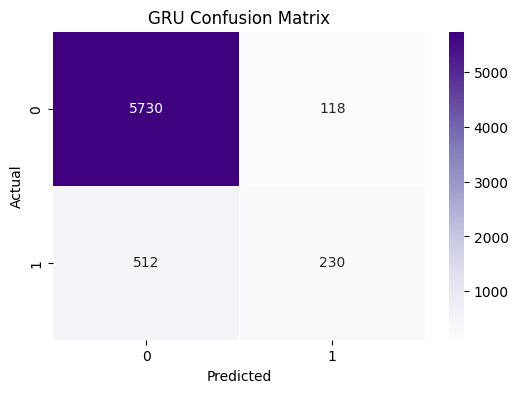


GRU Classification Report:

              precision    recall  f1-score   support

           0       0.92      0.98      0.95      5848
           1       0.66      0.31      0.42       742

    accuracy                           0.90      6590
   macro avg       0.79      0.64      0.68      6590
weighted avg       0.89      0.90      0.89      6590



In [26]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

val_pred_gru = (model_gru.predict(X_val_lstm) >= 0.5).astype(int)

cm_gru = confusion_matrix(y_val, val_pred_gru)

plt.figure(figsize=(6,4))
sns.heatmap(cm_gru, annot=True, fmt="d", cmap="Purples")
plt.title("GRU Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("\nGRU Classification Report:\n")
print(classification_report(y_val, val_pred_gru))

11.3 GRU Accuracy curve

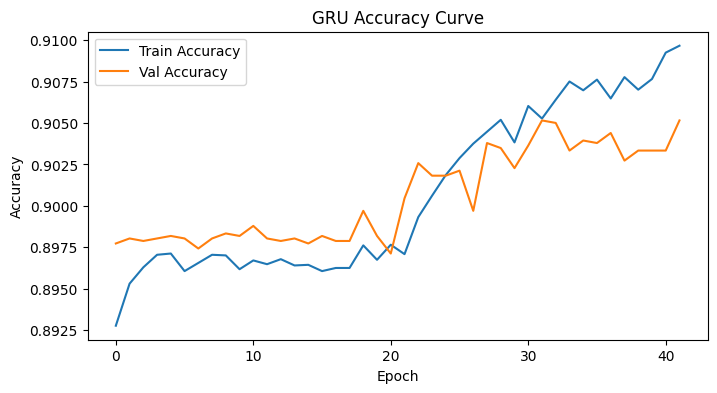

In [27]:
plt.figure(figsize=(8,4))
plt.plot(history_gru.history['accuracy'], label='Train Accuracy')
plt.plot(history_gru.history['val_accuracy'], label='Val Accuracy')
plt.title("GRU Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

11.4 GRU Loss Curve

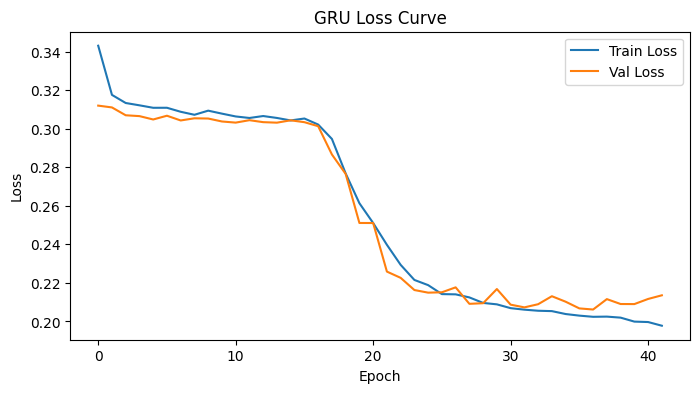

In [28]:
plt.figure(figsize=(8,4))
plt.plot(history_gru.history['loss'], label='Train Loss')
plt.plot(history_gru.history['val_loss'], label='Val Loss')
plt.title("GRU Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()